# Explore Predictions

In [15]:
from tensorflow import keras
from tensorflow.random import set_seed
from sklearn.preprocessing import StandardScaler

import plotly.graph_objects as go

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

import pandas as pd
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

## Load Data

Modify data name  
Modify timesteps

In [16]:
####
# MODIFY the time steps as you see fit, you may want to look at the number of points in a day, and choose that 
# Or choose any other time period 
####

TIMESTEP_LIST = [15, 30, 60, 120]

In [17]:
# Two options 'PD' or 'WINDOW'
# 'PD' for predicting next point
# 'WINDOW' for Sliding window
TYPE = 'PD'

In [18]:
THRESHOLD_LIST = [0.25, 0.33,0.65] # THESE ARE PERCENTAGES OF THE MAX MAE, A LOWER PERCENTAGE WILL FIND MORE ANOMALIES

In [19]:

TRAIN_ON_NORMAL = False # IF TRUE THEN REMOVE ROWS THAT HAVE HUMAN FLAGGED ANOMALIES

In [20]:
data_dir = "../../../data/labelled-skyspark-data/"
data_set_1_name = "CEC_compiled_data_1a_updated.csv"
data_set_2_name = "CEC_compiled_data_1b_updated.csv"

In [21]:
data_without_labels = pd.read_csv(data_dir + data_set_1_name)
data_without_labels = data_without_labels.rename(columns={'Anomaly': 'anomaly_by_human'})
data_without_labels.head()

,Datetime,Value,ID,anomaly_by_human
0,2020-01-01 07:58:52,9.6,Campus Energy Centre Campus HW Main Meter Power,False
1,2020-01-01 08:00:00,9.6,Campus Energy Centre Campus HW Main Meter Power,False
2,2020-01-01 08:01:34,10.3,Campus Energy Centre Campus HW Main Meter Power,False
3,2020-01-01 08:04:15,11.0,Campus Energy Centre Campus HW Main Meter Power,False
4,2020-01-01 08:07:36,10.3,Campus Energy Centre Campus HW Main Meter Power,False


In [22]:
data_with_labels = pd.read_csv(data_dir + data_set_2_name)
data_with_labels = data_with_labels.rename(columns={'Anomaly': 'anomaly_by_human'})
data_with_labels["anomaly_by_human"] = data_with_labels["anomaly_by_human"].apply(lambda x: str(x))
data_with_labels.head()

,Datetime,Value,ID,anomaly_by_human
0,2020-01-01 07:58:52,9.6,Campus Energy Centre Campus HW Main Meter Power,False
1,2020-01-01 08:00:00,9.6,Campus Energy Centre Campus HW Main Meter Power,False
2,2020-01-01 08:01:34,10.3,Campus Energy Centre Campus HW Main Meter Power,False
3,2020-01-01 08:04:15,11.0,Campus Energy Centre Campus HW Main Meter Power,False
4,2020-01-01 08:07:36,10.3,Campus Energy Centre Campus HW Main Meter Power,False


Some datasets have 3 versions (i.e seasonal anomalies not counted)  
Another `pd.read_csv()` call will need to be done here

# Split data into 60-40 train test split

In [23]:
PERCENT_TRAIN = 0.6
train_split_number = int(len(data_with_labels) * PERCENT_TRAIN)

test = data_with_labels.tail(len(data_with_labels) - train_split_number)
if TRAIN_ON_NORMAL:
  train = data_with_labels.head(train_split_number)
  train = train[train["anomaly_by_human"] == "False"]
else:
  train = data_without_labels.head(train_split_number)

# Create sequences of time steps

In [24]:
train["raw_value"] = train["Value"]
test["raw_value"] = test["Value"]

#test_raw = test["Value"].copy(deep=True)

scaler = StandardScaler()
scaler = scaler.fit(train[['Value']])

train['Value'] = scaler.transform(train[['Value']])
test['Value'] = scaler.transform(test[['Value']])

<ipython-input-24-b8cc291b610f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["raw_value"] = train["Value"]
<ipython-input-24-b8cc291b610f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["raw_value"] = test["Value"]
<ipython-input-24-b8cc291b610f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

In [25]:
def create_sequences(X, y, time_steps=30, window=1):
    Xs, ys = [], []
    for i in range(0,len(X)-time_steps, window):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

In [26]:
data_dict = {}

# If 0 then using predict
# If 1 then using reconstruction sliding window
if TYPE=='PD':
  on = 0
else:
  on = 1

for timestep in TIMESTEP_LIST:
    X_train, y_train = create_sequences(train[['Value']], train['Value'], time_steps=timestep, window=timestep**on)
    X_train_eval, y_train_eval =create_sequences(train[['Value']], train['Value'], time_steps=timestep)
    X_test, y_test = create_sequences(test[['Value']], test['Value'], time_steps=timestep)
    data_timestepped = {}
    data_timestepped["x_train"] = X_train
    data_timestepped["y_train"] = y_train
    data_timestepped["x_train_eval"] = X_train_eval
    data_timestepped["y_train_eval"] = y_train_eval
    data_timestepped["x_test"] = X_test
    data_timestepped["y_test"] = y_test
    data_dict[timestep] = data_timestepped


In [27]:
for ts in data_dict.keys():
    print("time step size", ts)
    for _, data_set in data_dict[ts].items():
      print(data_set.shape)
    print("\n")

time step size 15
(227892, 15, 1)
(227892,)
(227892, 15, 1)
(227892,)
(151924, 15, 1)
(151924,)


time step size 30
(227877, 30, 1)
(227877,)
(227877, 30, 1)
(227877,)
(151909, 30, 1)
(151909,)


time step size 60
(227847, 60, 1)
(227847,)
(227847, 60, 1)
(227847,)
(151879, 60, 1)
(151879,)


time step size 120
(227787, 120, 1)
(227787,)
(227787, 120, 1)
(227787,)
(151819, 120, 1)
(151819,)




In [28]:
test.head()

,Datetime,Value,ID,anomaly_by_human,raw_value
227907,2020-10-20 15:11:50,1.830657,Campus Energy Centre Campus HW Main Meter Power,False,23.500000
227908,2020-10-20 15:12:50,1.629875,Campus Energy Centre Campus HW Main Meter Power,False,22.000000
227909,2020-10-20 15:13:51,1.496020,Campus Energy Centre Campus HW Main Meter Power,False,21.000000
227910,2020-10-20 15:15:02,1.616489,Campus Energy Centre Campus HW Main Meter Power,False,21.900000
227911,2020-10-20 15:16:02,1.723573,Campus Energy Centre Campus HW Main Meter Power,False,22.700001


# Step up model

In [29]:
def create_model(x_input, switch):
  set_seed(2s)
  model = Sequential()
  model.add(LSTM(128, input_shape=(x_input.shape[1], x_input.shape[2])))
  model.add(Dropout(rate=0.2))
  model.add(RepeatVector(x_input.shape[1]**switch))
  model.add(LSTM(128, return_sequences=True))
  model.add(Dropout(rate=0.2))
  model.add(TimeDistributed(Dense(x_input.shape[2])))
  model.compile(optimizer='adam', loss='mae')
  model.summary()
  return model

# Train a Model for Each timestep

In [30]:
# if "x_train" reconstruction of window
# if "y_train" prediciting following value
if on == 1:
  y_val = "x_train"
else:
  y_val = "y_train"

for key, inner_data in data_dict.items():
    x_train = inner_data["x_train"]
    y_train = inner_data[y_val]
    print(x_train.shape)
    print(y_train.shape)
    model = create_model(x_train, on)
    history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.1,
                        callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')], shuffle=False)
    inner_data["history"] = history
    inner_data["model"] = model
    model = None

(227892, 15, 1)
(227892,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 128)            131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 128)            0         
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 1)              129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
________________________

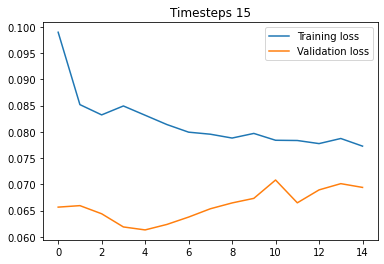

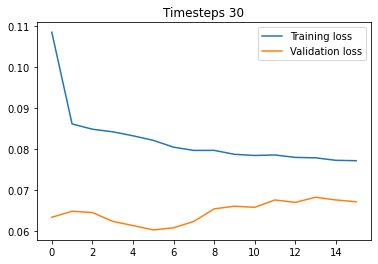

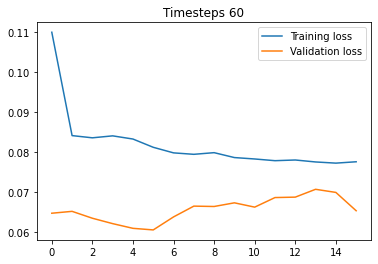

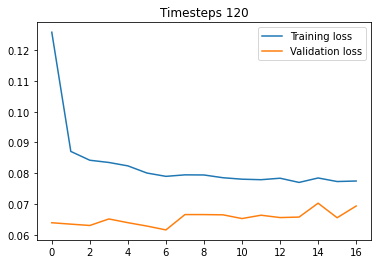

In [31]:
for ts in data_dict.keys():
  history = data_dict[ts]["history"]
  plt.plot(history.history['loss'], label='Training loss')
  plt.plot(history.history['val_loss'], label='Validation loss')
  plt.title("Timesteps {}".format(ts))
  plt.legend();
  plt.show()

In [32]:
for ts in data_dict.keys():
  print("evaluating for timestep: {}".format(ts))
  x_test = data_dict[ts]["x_test"]
  y_test = data_dict[ts]["y_test"]
  model = data_dict[ts]["model"]
  print(model.evaluate(x_test, y_test))

evaluating for timestep: 15
4748/4748 [==============================] - 14s 3ms/step - loss: 0.1548
0.15484310686588287
evaluating for timestep: 30
4748/4748 [==============================] - 24s 5ms/step - loss: 0.1538
0.1538490206003189
evaluating for timestep: 60
4747/4747 [==============================] - 41s 9ms/step - loss: 0.1226
0.12262266874313354
evaluating for timestep: 120
4745/4745 [==============================] - 86s 18ms/step - loss: 0.1696
0.169595405459404


In [33]:
for ts in data_dict.keys():
  print("computing info for {}".format(ts))
  model = data_dict[ts]["model"]
  x_train = data_dict[ts]["x_train_eval"]
  y_train = data_dict[ts]["y_train_eval"]
  x_test = data_dict[ts]["x_test"]
  y_test = data_dict[ts]["y_test"]


  x_train_pred = model.predict(x_train, verbose=0)
  if on == 1:
    train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)
    train_score_df = pd.DataFrame(train[ts-1:-1])
    train_score_df['loss'] = train_mae_loss
    train_score_df['Value'] = train[ts-1:-1]['Value']
  else:
    train_mae_loss = np.abs(x_train_pred.flatten()-y_train)
    train_score_df = pd.DataFrame(train[ts:])
    train_score_df['loss'] = train_mae_loss
    train_score_df['Value'] = train[ts:]['Value']
  data_dict[ts]["train_score_df"] = train_score_df

  x_test_pred = model.predict(x_test, verbose=0)
  if on == 1:
    test_mae_loss = np.mean(np.abs(x_test_pred-x_test), axis=1)
    test_score_df = pd.DataFrame(test[ts-1:-1])
    test_score_df['loss'] = test_mae_loss
    test_score_df['Value'] = test[ts-1:-1]['Value']
  else:
    test_mae_loss = np.abs(x_test_pred.flatten()-y_test)
    test_score_df = pd.DataFrame(test[ts:])
    test_score_df['loss'] = test_mae_loss
    test_score_df['Value'] = test[ts:]['Value']
  data_dict[ts]["test_score_df"] = test_score_df

computing info for 15
computing info for 30
computing info for 60
computing info for 120


Calculates anomalies based on different thresholds, If you want to try different values change `THRESHOLD_LIST` at the top of the notebook, or define it again here with new values

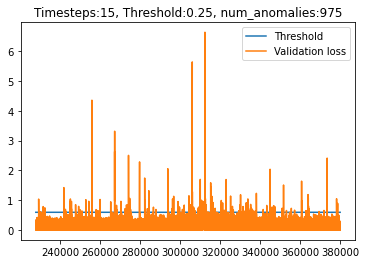

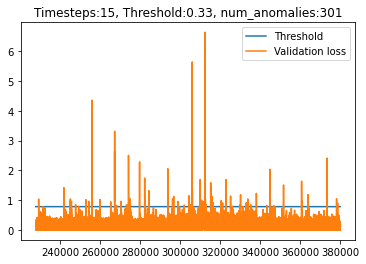

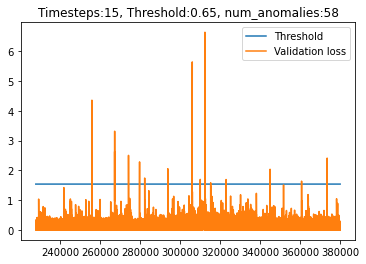

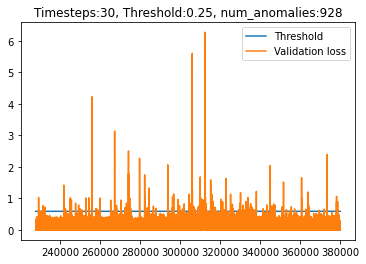

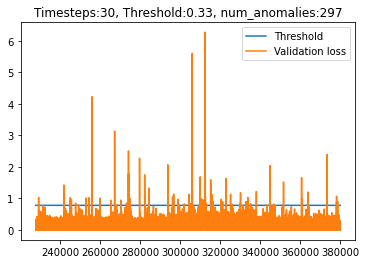

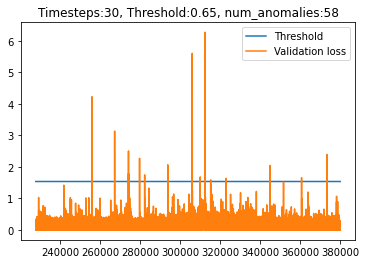

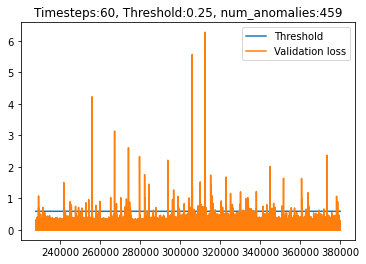

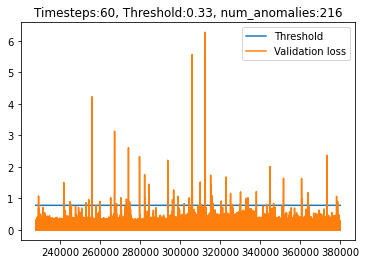

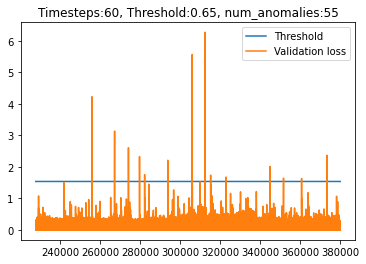

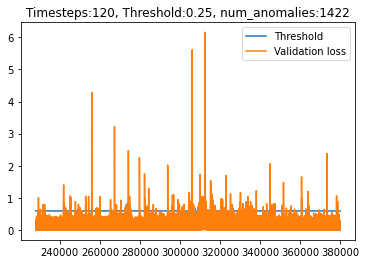

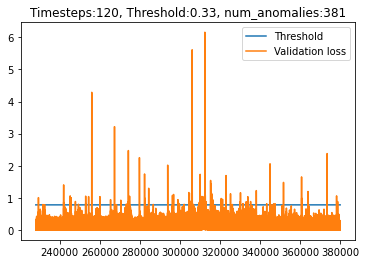

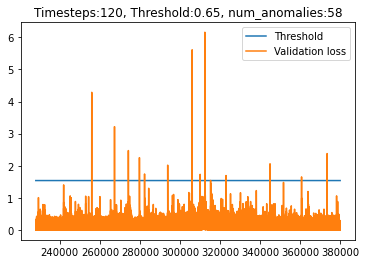

In [34]:
for ts in data_dict.keys():
  for thresh in THRESHOLD_LIST:

    test_score_df = data_dict[ts]["test_score_df"]
    #test_score_df = data_dict[ts]["test_score_df"].copy(deep=True)
    max_error = train_score_df["loss"].max()
    threshold = max_error * thresh
    
    test_score_df['threshold'] = threshold
    test_score_df['anomaly_by_machine'] = test_score_df['loss'] > test_score_df['threshold']

    anomalies = test_score_df.loc[test_score_df['anomaly_by_machine'] == True]
    num_anomalies = anomalies.shape[0]

    plt.plot(test_score_df['threshold'], label='Threshold')
    plt.plot(test_score_df['loss'], label='Validation loss')
    plt.title("Timesteps:{}, Threshold:{}, num_anomalies:{}".format(ts, thresh, num_anomalies))
    plt.legend();
    plt.show()

## PD
## 15 Window
![](images/dataset-1/data_1a_PD_ts_15_thresh_25_a.png)
![](images/dataset-1/data_1a_PD_ts_15_thresh_25_b.png)
![](images/dataset-1/data_1a_PD_ts_15_thresh_25_c.png)
![](images/dataset-1/data_1a_PD_ts_15_thresh_25_d.png)
![](images/dataset-1/data_1a_PD_ts_15_thresh_25_e.png)
![](images/dataset-1/data_1a_PD_ts_15_thresh_33_a.png)
![](images/dataset-1/data_1a_PD_ts_15_thresh_33_b.png)
![](images/dataset-1/data_1a_PD_ts_15_thresh_33_c.png)
![](images/dataset-1/data_1a_PD_ts_15_thresh_33_d.png)
![](images/dataset-1/data_1a_PD_ts_15_thresh_33_e.png)
![](images/dataset-1/data_1a_PD_ts_15_thresh_33_f.png)
![](images/dataset-1/data_1a_PD_ts_15_thresh_50_a.png)

## 30 Window
![](images/dataset-1/data_1a_PD_ts_30_thresh_25_a.png)
![](images/dataset-1/data_1a_PD_ts_30_thresh_25_b.png)
![](images/dataset-1/data_1a_PD_ts_30_thresh_25_c.png)
![](images/dataset-1/data_1a_PD_ts_30_thresh_25_d.png)
![](images/dataset-1/data_1a_PD_ts_30_thresh_25_e.png)
![](images/dataset-1/data_1a_PD_ts_30_thresh_25_f.png)
![](images/dataset-1/data_1a_PD_ts_30_thresh_33_a.png)
![](images/dataset-1/data_1a_PD_ts_30_thresh_50_a.png)

## 60 Window
![](images/dataset-1/data_1a_PD_ts_60_thresh_25_a.png)
![](images/dataset-1/data_1a_PD_ts_60_thresh_25_b.png)
![](images/dataset-1/data_1a_PD_ts_60_thresh_25_c.png)
![](images/dataset-1/data_1a_PD_ts_60_thresh_25_d.png)
![](images/dataset-1/data_1a_PD_ts_60_thresh_25_e.png)
![](images/dataset-1/data_1a_PD_ts_60_thresh_25_f.png)
![](images/dataset-1/data_1a_PD_ts_60_thresh_33_a.png)
![](images/dataset-1/data_1a_PD_ts_60_thresh_50_a.png)

## 120 Window
![](images/dataset-1/data_1a_PD_ts_120_thresh_25_a.png)
![](images/dataset-1/data_1a_PD_ts_120_thresh_25_b.png)
![](images/dataset-1/data_1a_PD_ts_120_thresh_25_c.png)
![](images/dataset-1/data_1a_PD_ts_120_thresh_25_d.png)
![](images/dataset-1/data_1a_PD_ts_120_thresh_25_e.png)
![](images/dataset-1/data_1a_PD_ts_120_thresh_25_f.png)
![](images/dataset-1/data_1a_PD_ts_120_thresh_33_a.png)
![](images/dataset-1/data_1a_PD_ts_120_thresh_33_b.png)
![](images/dataset-1/data_1a_PD_ts_120_thresh_33_c.png)
![](images/dataset-1/data_1a_PD_ts_120_thresh_33_d.png)
![](images/dataset-1/data_1a_PD_ts_120_thresh_33_e.png)
![](images/dataset-1/data_1a_PD_ts_120_thresh_33_f.png)
![](images/dataset-1/data_1a_PD_ts_120_thresh_33_g.png)
![](images/dataset-1/data_1a_PD_ts_120_thresh_33_h.png)
![](images/dataset-1/data_1a_PD_ts_120_thresh_50_a.png)

## Comparison versus trained on normal data  

Normal  
![](images/dataset-1/data_1b_PD_ts_15_thresh_25_a.png)  
All data  
![](images/dataset-1/data_1a_PD_ts_15_thresh_25_a.png)  
Normal  
![](images/dataset-1/data_1b_PD_ts_15_thresh_25_b.png)  
All data  
![](images/dataset-1/data_1a_PD_ts_15_thresh_25_b.png)  
Normal  
![](images/dataset-1/data_1b_PD_ts_120_thresh_25_a.png)  
All data  
![](images/dataset-1/data_1a_PD_ts_120_thresh_25_a.png)  
Normal  
![](images/dataset-1/data_1b_PD_ts_120_thresh_25_b.png)  
All data  
![](images/dataset-1/data_1a_PD_ts_120_thresh_25_b.png)  

In [35]:
# for ts in data_dict.keys():
#   for thresh in THRESHOLD_LIST[0:2]:
#     test_score_df = data_dict[ts]["test_score_df"]
#     #test_score_df = data_dict[ts]["test_score_df"].copy(deep=True)
#     max_error = train_score_df["loss"].max()
#     threshold = max_error * thresh
   
#     test_score_df['threshold'] = threshold
#     test_score_df['anomaly_by_machine'] = test_score_df['loss'] > test_score_df['threshold']
#     test_score_df["raw_value"] = test["raw_value"][ts:]
#     test_score_df["anomaly_by_machine_int"] = test_score_df['anomaly_by_machine'].apply(lambda x: str(x))

#     test_score_df["year_month"] = test_score_df["Datetime"].apply(lambda x: "-".join(x.split("-")[0:2]))

    
#     fig = px.scatter(test_score_df, x="Datetime", y="raw_value", color="anomaly_by_machine_int", 
#                      title="Anomalies Detected for Timestep:{}, Threshold:{}".format(ts, thresh))
    
#     human_anomalies = test[test["anomaly_by_human"] == "True"]
   
#     fig.add_trace(go.Scatter(x=human_anomalies["Datetime"], y=human_anomalies["raw_value"], mode="markers",
#                 marker=dict(size=10, color="Black"),
#                 name="anomaly_by_human=True"))

#     fig.show()


In [36]:
# for thresh in THRESHOLD_LIST:
#   for ts in data_dict.keys():

#     test_score_df = data_dict[ts]["test_score_df"]
#     #test_score_df = data_dict[ts]["test_score_df"].copy(deep=True)
#     max_error = train_score_df["loss"].max()
#     threshold = max_error * thresh
    
#     test_score_df['threshold'] = threshold
#     test_score_df['anomaly_by_machine'] = test_score_df['loss'] > test_score_df['threshold']
#     test_score_df["raw_value"] = test["raw_value"][ts-on:]
#     test_score_df["anomaly_by_machine_int"] = test_score_df['anomaly_by_machine'].apply(lambda x: str(x))

#     test_score_df["year_month"] = test_score_df["Datetime"].apply(lambda x: "-".join(x.split("-")[0:2]))

    
#     fig = px.scatter(test_score_df, x="Datetime", y="raw_value", color="anomaly_by_machine_int", 
#                      title="Anomalies Detected for Timestep:{}, Threshold:{}".format(ts, thresh))
    
#     human_anomalies = test[test["anomaly_by_human"] == "True"]
    
#     fig.add_trace(go.Scatter(x=human_anomalies["Datetime"], y=human_anomalies["raw_value"], mode="markers",
#                 marker=dict(size=10, color="Black"),
#                 name="anomaly_by_human=True"))

#     fig.show()